In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import torch
from evaluate_classif import plot_tsne, test_rodie
from tqdm import tqdm
from preprocessing import *
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding ,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm
## Those settings speed up the training process on GPU
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [4]:

## Download data
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-23 15:44:15--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  4.90MB/s    in 1.0s    

2022-03-23 15:44:17 (4.90 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [5]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [6]:
mooc_data = extract_data_mooc()

In [7]:
## Extract time diffs for both users and items interactions
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
## Standardize the columns
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)

In [8]:
## Extract previous item interactions and past user state
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)
interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0

In [ ]:
data = mooc_data.copy()
data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data.head()

### T-batches

#### Train / Test SPLIT

In [10]:
t_batches = t_batch_update(data)

T-Batch start...
Number of interaction = 411749
Number of batch = 63461
T-Batch ends !


In [11]:
t_batch_train, valid_test, train_interactions, test_interactions = t_batch_train_test(data,t_batches,39917)

Train : Number of interactions in 39917 batches is equal to 247051
Test : Number of interactions is equal to 164698


##### Initialize Device

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [54]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio_train = len(train_interactions)/(1.0+ np.sum(data.loc[train_interactions,'state_label']))
weight_ratio_train = torch.Tensor([1.0,dropout_ratio_train]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[train_interactions,'state_label'])))

int_test = valid_test.index.values.tolist()
dropout_ratio_test = len(int_test)/(1.0+ np.sum(data.loc[int_test,'state_label']))
weight_ratio_test = torch.Tensor([1.0,dropout_ratio_test]).to(device)

print("Number of dropout in the test data is {}".format(np.sum(data.loc[test_interactions,'state_label'])))


Number of dropout in the train data is 2588
Number of dropout in the test data is 1478


In [55]:
valid_data,test_data = valid_test[:int(len(valid_test)/2)].copy(), valid_test[int(len(valid_test)/2):].copy()

##### Train Loop

In [ ]:
weight_ratio_train,weight_ratio_test

In [ ]:
embedding_dim = 32
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)

n_epochs = 10
lambda_u = 1
lambda_i = 1
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I,loss_list,valid_loss = train_rodie(t_batch_train,
          data_torch,
          valid_data,
          train_interactions,
          weight_ratio_train,
          weight_ratio_test,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

In [ ]:
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)
model_weight = torch.load("/content/modelFinal_ep9")
model.load_state_dict(model_weight)

y, pred,U_test,I_test,auc,test_loss = test_rodie(test_data,weight_ratio_test, U, I, data_torch, model ,device)


In [53]:
auc

0.6891580003980103

## TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


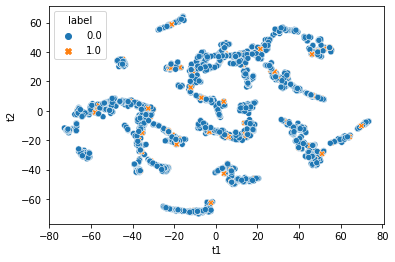

In [ ]:
tsne_embedding_users = plot_tsne(data,U,test_interactions[:int(len(test_interactions)/2)],"user_id")


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


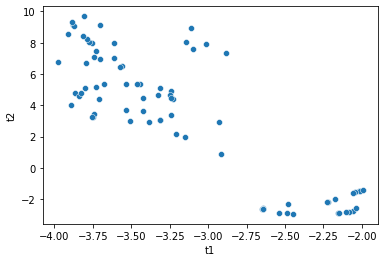

In [ ]:
tsne_embedding_items = plot_tsne(data,I,test_interactions[:int(len(test_interactions)/2)],"item_id")

# Testing

In [ ]:
y, pred,auc = test_rodie(test_data,weight_ratio_test, U, I, data_torch, model_, device)

Testing...


 99%|█████████▉| 160/161 [00:04<00:00, 32.05it/s]


ValueError: ignored